<a href="https://colab.research.google.com/github/Anderson-Andre-P/Summary-Generator-With-Python-and-NLTK/blob/main/SummarizerAlgorithm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPDF2
!pip install reportlab
!pip install rouge
!pip install python-docx
!pip install gradio

import gradio as gr
from docx import Document
from google.colab import files
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
import heapq
import re
import io
from reportlab.pdfgen import canvas
import textwrap
import PyPDF2
from PyPDF2 import PdfFileReader, PdfFileWriter
from rouge import Rouge

import matplotlib.pyplot as plt
from collections import defaultdict

Saving article.pdf to article (4).pdf
Resumo:   Ann R Coll Surg Engl Artificial intelligence AI is defined as a field of science and engineering concerned with the computational understanding of what is commonly called intelligentbehaviour and with the creation of artefacts that exhibitsuch behaviour Aristotle attempted to formalise right thinking logic through his syllogisms a three partdeductive reasoning Much of the work in the modern erawas inspired by this and the early studies on the operationof mind helped to establish contemporary logical thinkingPrograms which enable computers to function in the waysthat make people seem intelligent are called artificialintelligent systems The British mathematician Alan Turing was one of the founders of modern computer scienceand AI He defined intelligent behaviour in a computer asthe ability to achieve humanlevel performance in cognitive tasks this later became popular as the Turing test Since the middle of the last century researchers have e

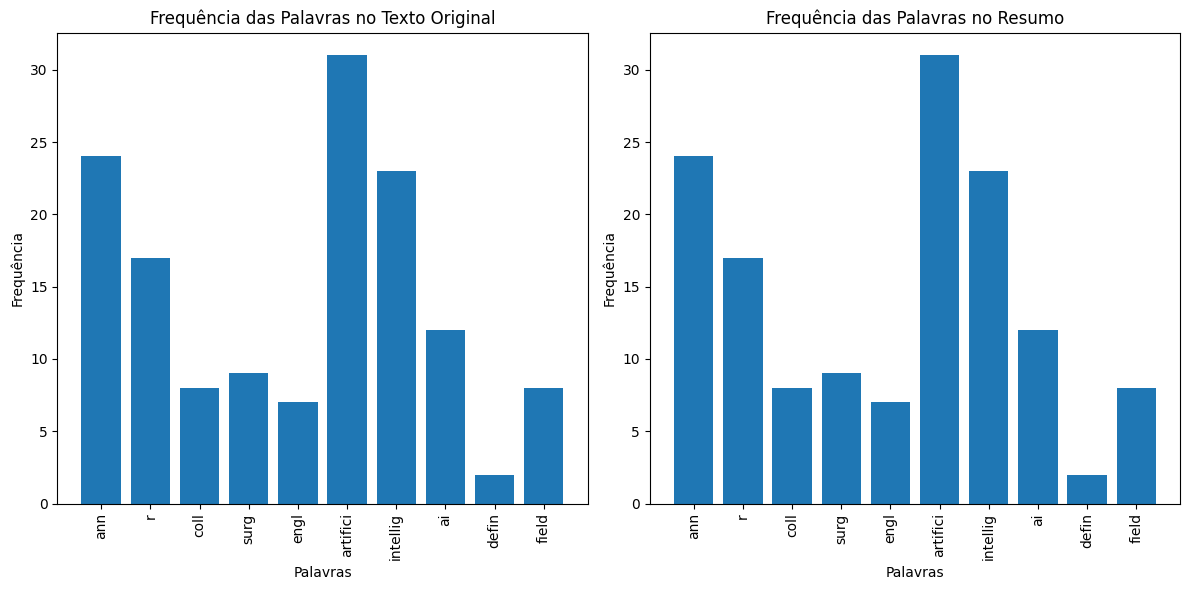

In [ ]:
def read_pdf_text(pdf_file):
    pdf_text = ""
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    for page in pdf_reader.pages:
        pdf_text += page.extract_text()
    pdf_text = ' '.join(pdf_text.split())
    return pdf_text

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[0-9]', ' ', text)
    text = re.sub(r' +', ' ', text)
    return text

def tokenize_text(text):
    palavras = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    palavras_sem_stopwords = [palavra for palavra in palavras if palavra not in stop_words and palavra.isalpha()]
    ps = PorterStemmer()
    palavras_stemmed = [ps.stem(palavra) for palavra in palavras_sem_stopwords]
    return palavras_stemmed

def calculate_word_frequency(palavras_stemmed):
    return nltk.FreqDist(palavras_stemmed)

def score_sentences(sentences, frequency_dist):
    pontuacao_sentencas = {}
    for sentenca in sentences:
        for palavra in word_tokenize(sentenca.lower()):
            if palavra in frequency_dist:
                if sentenca not in pontuacao_sentencas:
                    pontuacao_sentencas[sentenca] = frequency_dist[palavra]
                else:
                    pontuacao_sentencas[sentenca] += frequency_dist[palavra]
    return pontuacao_sentencas

def summarize_text(sentences, scores, num_sentences=1000):
    melhores_sentencas = heapq.nlargest(num_sentences, scores, key=scores.get)
    return ' '.join(melhores_sentencas)

def adicionar_quebras_de_linha(texto, caracteres_por_linha=75):
    linhas = textwrap.wrap(texto, caracteres_por_linha)
    return "\n".join(linhas)

def criar_pdf(resumo, arquivo_pdf_path, caracteres_por_linha=70):
    buffer = io.BytesIO()
    pdf_canvas = canvas.Canvas(buffer)

    paginas_do_resumo = textwrap.wrap(resumo, caracteres_por_linha)

    x, y = 100, 750

    for indice_pagina, pagina in enumerate(paginas_do_resumo):
        pdf_canvas.drawString(x, y, pagina)
        y -= 15
        if indice_pagina < len(paginas_do_resumo) - 1 and y <= 100:
            pdf_canvas.showPage()
            y = 750

    pdf_canvas.save()

    with open(arquivo_pdf_path, "wb") as output_file:
        output_file.write(buffer.getvalue())

    return arquivo_pdf_path

def build_similarity_matrix(sentences, word_tokens):
    ps = PorterStemmer()
    word_tokens_stemmed = [ps.stem(word) for word in word_tokens]

    word_sent_count = defaultdict(int)
    for word in word_tokens_stemmed:
        for sent in sentences:
            if word in word_tokenize(sent.lower()):
                word_sent_count[sent] += 1

    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for i, sent1 in enumerate(sentences):
        for j, sent2 in enumerate(sentences):
            for word in word_tokenize(sent1.lower()):
                if ps.stem(word) in word_tokens_stemmed:
                    similarity_matrix[i, j] += word_sent_count[sent2]

    max_score = np.max(similarity_matrix)
    if max_score != 0:
        similarity_matrix /= max_score

    return similarity_matrix

def main():
    pdf_file_path_dict = files.upload()
    pdf_file_path = next(iter(pdf_file_path_dict))
    with open(pdf_file_path, 'rb') as pdf_file:
        pdf_text = read_pdf_text(pdf_file)
    cleaned_text = clean_text(pdf_text)
    palavras_stemmed = tokenize_text(cleaned_text)
    frequency_dist = calculate_word_frequency(palavras_stemmed)
    sentencas = sent_tokenize(cleaned_text)
    pontuacao_sentencas = score_sentences(sentencas, frequency_dist)
    resumo = summarize_text(sentencas, pontuacao_sentencas, num_sentences=5)

    print("Resumo: ", resumo)

    resumo_formatado = adicionar_quebras_de_linha(resumo, caracteres_por_linha=70)

    pdf_path = criar_pdf(resumo_formatado, 'summary.pdf', caracteres_por_linha=70)
    print("Resumo salvo em:", pdf_path)


    words_original = list(frequency_dist.keys())
    frequency_original = list(frequency_dist.values())

    frequency_dist_resumo = nltk.FreqDist(tokenize_text(resumo.lower()))
    words_resumo = list(frequency_dist_resumo.keys())
    frequency_resumo = list(frequency_dist_resumo.values())

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(words_original[:10], frequency_original[:10])
    plt.xticks(rotation=90)
    plt.xlabel('Palavras')
    plt.ylabel('Frequência')
    plt.title('Frequência das Palavras no Texto Original')

    plt.subplot(1, 2, 2)
    plt.bar(words_resumo[:10], frequency_resumo[:10])
    plt.xticks(rotation=90)
    plt.xlabel('Palavras')
    plt.ylabel('Frequência')
    plt.title('Frequência das Palavras no Resumo')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
def summarizer_interface(pdf_file_path):
    with open(pdf_file_path, 'rb') as pdf_file:
        pdf_text = read_pdf_text(pdf_file)
    cleaned_text = clean_text(pdf_text)
    palavras_stemmed = tokenize_text(cleaned_text)
    frequency_dist = calculate_word_frequency(palavras_stemmed)
    sentencas = sent_tokenize(cleaned_text)
    pontuacao_sentencas = score_sentences(sentencas, frequency_dist)
    resumo = summarize_text(sentencas, pontuacao_sentencas, num_sentences=5)

    return resumo

def on_submit(file):
    return summarizer_interface(file.name)

inputs = gr.inputs.File(label="Selecione um arquivo PDF", type="file")
outputs = gr.outputs.Textbox()

gr.Interface(fn=on_submit, inputs=inputs, outputs=outputs, live=False, capture_session=True, title="Resumo de PDF", description="Selecione um arquivo PDF e clique em Enviar para gerar o resumo.").launch()

<ipython-input-74-54cd02e6d887>:18: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs = gr.inputs.File(label="Selecione um arquivo PDF", type="file")
<ipython-input-74-54cd02e6d887>:18: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs = gr.inputs.File(label="Selecione um arquivo PDF", type="file")
<ipython-input-74-54cd02e6d887>:18: GradioDeprecationWarning: `keep_filename` parameter is deprecated, and it has no effect
  inputs = gr.inputs.File(label="Selecione um arquivo PDF", type="file")
<ipython-input-74-54cd02e6d887>:19: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs = gr.outputs.Textbox()
<ipython-input-74-54cd02e6d887>:22: GradioDeprecationWarning: `capture_session` parameter is deprecated, and it has n

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>